In [8]:
from google.colab import drive
drive.mount('/content/drive')
from tqdm.notebook import tqdm

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm.notebook import tqdm

In [9]:
!unzip '/content/drive/My Drive/Data/MSDS/Semester2/Deeplearning/assignment5/data/Assignment 5 Dataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Assignment 5 Dataset/train/normal/7ec0b033-9133-4f8c-abd0-ea246aa21dfa.png  
  inflating: Assignment 5 Dataset/train/normal/7ec4666c-0304-4b7b-8263-bf417ab7cccd.png  
  inflating: Assignment 5 Dataset/train/normal/7ee9ace4-3059-49c4-9356-705203289e46.png  
  inflating: Assignment 5 Dataset/train/normal/7ef283b8-9c5a-4ada-a575-f68289e338ae.png  
  inflating: Assignment 5 Dataset/train/normal/7ef98cac-f239-406e-af10-67aead1e038f.png  
  inflating: Assignment 5 Dataset/train/normal/7efb172c-23b7-4d57-bd57-bd461b9e7ca7.png  
  inflating: Assignment 5 Dataset/train/normal/7f015127-0907-4ba7-8021-cf868a210d4c.png  
  inflating: Assignment 5 Dataset/train/normal/7f05b70f-2ad0-4db6-9e05-6c2baec8cd52.png  
  inflating: Assignment 5 Dataset/train/normal/7f11cf49-7b97-4d39-82a1-18411a4599cd.png  
  inflating: Assignment 5 Dataset/train/normal/7f12966e-c382-4f9e-90ac-e1575dcdc812.png  
  inflating: Assignment 5 Dataset/train/normal/7f

In [0]:
data_dir = '/content/Assignment 5 Dataset'

In [11]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
validation_data = datasets.ImageFolder(data_dir + '/validation', transform=test_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4)
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=64, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True, num_workers=4)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['infected', 'normal']


In [0]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  plt.axis('off')
  plt.imshow(inp)
  if title is not None:
      plt.title(title)
  plt.pause(0.001)

def show_databatch(inputs, classes):
  out = torchvision.utils.make_grid(inputs)
  imshow(out, title=[class_names[x] for x in classes])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


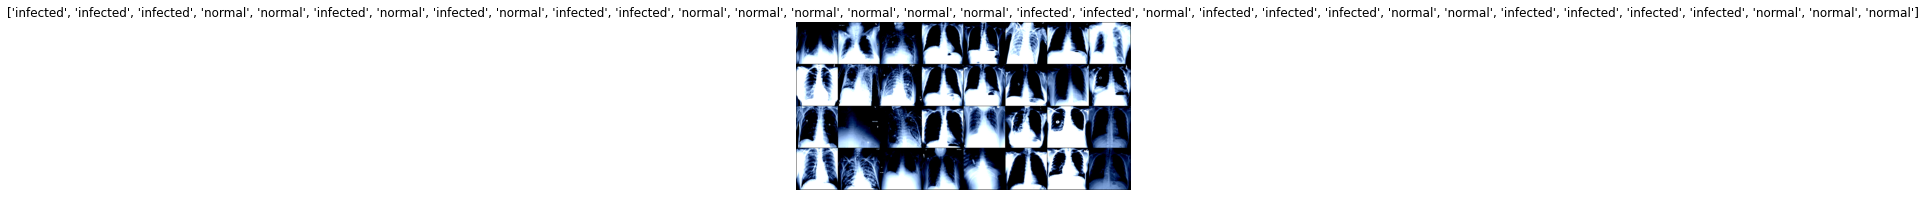

In [0]:
# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

In [0]:
print('Train: ', len(train_data))
print('Validation: ', len(validation_data))
print('Test: ', len(test_data))

Train:  12000
Validation:  1500
Test:  1500


In [0]:
def train(model, lr,epochs, l1, l2,trainacc, validationacc, trainloss, validationloss):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr, momentum=0.9)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model.to(device)
  model.train()
  for epoch in range(epochs):  
    running_loss = 0.0

    trainacctemp = 0
    validationacctemp = 0
    testingacctemp = 0
    trainlosstemp = 0
    validationlosstemp = 0
    correct = 0
    total = 0
    pbar = tqdm(enumerate(l1))
    for i, data in pbar:
      #train
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      trainacctemp += 100 * correct / total

      loss = criterion(outputs, labels)   #----> compute loss
      loss.backward()                     #----> backward pass
      optimizer.step()                    #----> weights update

      trainlosstemp += loss.item()
      print('\rEpoch: ', epoch, ' item: ', i * len(inputs), ' total item: ', len(l1.dataset), end='')
      # pbar.set_description('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
      #           epoch, i * len(inputs), len(trainloader.dataset),100. * i / len(trainloader), len(trainloader.dataset)/64)))

    #validation
    correct = 0
    total = 0
    pbar = tqdm(enumerate(l2))
    for i, data in pbar:
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      validationacctemp += 100 * correct / total

      loss = criterion(outputs, labels)   #----> compute loss
      # loss.backward()                     #----> backward pass
      # optimizer.step()                    #----> weights update
      validationlosstemp += loss.item()
      print('\rEpoch: ', epoch, ' item: ', i * len(inputs), ' total item: ', len(l2.dataset), end='')
    tacc = trainacctemp/(len(l1.dataset)/64)
    vacc = validationacctemp/(len(l2.dataset)/64)

    tloss = trainlosstemp/(len(l1.dataset)/64)
    vloss = validationlosstemp/(len(l2.dataset)/64)
    trainacc.append(tacc)
    trainloss.append(tloss)
    validationacc.append(vacc)
    validationloss.append(vloss)
    print('\rEpoch: ', epoch, '\tTraining accuracy: ', tacc, '\tValidation accuracy: ', vacc, '\tTraining loss: ', tloss, '\tValidation loss: ', vloss)
  return trainacc, validationacc, trainloss, validationloss, model

VGG FC layer

In [0]:
# Load the pretrained model from pytorch
vgg16_1 = models.vgg16(pretrained=True)
print(vgg16_1)
print('Output Layer of VGG16 : ', vgg16_1.classifier[6].out_features) # 1000 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
num_features = vgg16_1.classifier[0].in_features
vgg16_1.classifier = vgg16_1.classifier[:4]
vgg16_1.classifier[0] = nn.Linear(num_features, 210)
vgg16_1.classifier[3] = nn.Linear(210, len(class_names))
# vgg16_1.load_state_dict(torch.load('/content/drive/My Drive/Data/MSDS/Semester2/Deeplearning/assignment5/vgg16_FC_Only.pth', map_location=torch.device('cpu')))
vgg16_1

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
trainacc_vgg_fc, validationacc_vgg_fc, trainloss_vgg_fc, validationloss_vgg_fc, vgg16_1 = train(vgg16_1, 0.000005,20, trainloader, validationloader, trainacc_vgg_fc, validationacc_vgg_fc, trainloss_vgg_fc, validationloss_vgg_fc)

Epoch:  0  item:  11992  total item:  12000


Epoch:  0  item:  748  total item:  1500
Epoch:  0 	Training accuracy:  73.69650621406508 	Validation accuracy:  82.84432963472221 	Training loss:  0.4585692916313807 	Validation loss:  0.4047583049535751


Epoch:  1  item:  11992  total item:  12000


Epoch:  1  item:  748  total item:  1500
Epoch:  1 	Training accuracy:  85.86707402367986 	Validation accuracy:  85.32061556529347 	Training loss:  0.34370129491885504 	Validation loss:  0.37185472484429677


Epoch:  2  item:  11992  total item:  12000


Epoch:  2  item:  748  total item:  1500
Epoch:  2 	Training accuracy:  87.48371280615372 	Validation accuracy:  83.64309577132495 	Training loss:  0.3161936510453622 	Validation loss:  0.34666936604181925


Epoch:  3  item:  11992  total item:  12000


Epoch:  3  item:  748  total item:  1500
Epoch:  3 	Training accuracy:  88.84611299024844 	Validation accuracy:  85.9924330208872 	Training loss:  0.29258829554418725 	Validation loss:  0.3468884932597478


Epoch:  4  item:  11992  total item:  12000


Epoch:  4  item:  748  total item:  1500
Epoch:  4 	Training accuracy:  88.19484843632843 	Validation accuracy:  85.44961365374695 	Training loss:  0.2827001355290413 	Validation loss:  0.3320757357676824


Epoch:  5  item:  11992  total item:  12000


Epoch:  5  item:  748  total item:  1500
Epoch:  5 	Training accuracy:  89.56249664704214 	Validation accuracy:  86.65356847331441 	Training loss:  0.2673868862291177 	Validation loss:  0.32345270669460296


Epoch:  6  item:  11992  total item:  12000


Epoch:  6  item:  748  total item:  1500
Epoch:  6 	Training accuracy:  89.60912283071612 	Validation accuracy:  85.93067682555247 	Training loss:  0.26112785082062084 	Validation loss:  0.32347703850269316


Epoch:  7  item:  11992  total item:  12000


Epoch:  7  item:  748  total item:  1500
Epoch:  7 	Training accuracy:  89.676051630462 	Validation accuracy:  88.21415235444519 	Training loss:  0.25707889899859826 	Validation loss:  0.31544327958424884


Epoch:  8  item:  11992  total item:  12000


Epoch:  8  item:  748  total item:  1500
Epoch:  8 	Training accuracy:  90.18904607689022 	Validation accuracy:  87.47222940415725 	Training loss:  0.24748023544251918 	Validation loss:  0.30521290258566536


Epoch:  9  item:  11992  total item:  12000


Epoch:  9  item:  748  total item:  1500
Epoch:  9 	Training accuracy:  90.43436752716758 	Validation accuracy:  88.0348661978554 	Training loss:  0.24212080443402131 	Validation loss:  0.30274056923389436


Epoch:  10  item:  11992  total item:  12000


Epoch:  10  item:  748  total item:  1500
Epoch:  10 	Training accuracy:  90.48437999206587 	Validation accuracy:  88.30161873875466 	Training loss:  0.2384164255137245 	Validation loss:  0.30385728454589844


Epoch:  11  item:  11992  total item:  12000


Epoch:  11  item:  748  total item:  1500
Epoch:  11 	Training accuracy:  90.9850417304282 	Validation accuracy:  87.95143902181155 	Training loss:  0.23371987799555063 	Validation loss:  0.3015786848862966


Epoch:  12  item:  11992  total item:  12000


Epoch:  12  item:  748  total item:  1500
Epoch:  12 	Training accuracy:  91.48449662680338 	Validation accuracy:  86.45459507780474 	Training loss:  0.22944507446388404 	Validation loss:  0.2978091661930084


Epoch:  13  item:  11992  total item:  12000


Epoch:  13  item:  748  total item:  1500
Epoch:  13 	Training accuracy:  91.4135123590588 	Validation accuracy:  88.16325869615882 	Training loss:  0.2259870857745409 	Validation loss:  0.28766127324104307


Epoch:  14  item:  11992  total item:  12000


Epoch:  14  item:  748  total item:  1500
Epoch:  14 	Training accuracy:  91.37714835022722 	Validation accuracy:  88.63926265723101 	Training loss:  0.2233379824757576 	Validation loss:  0.2958516914844513


Epoch:  15  item:  11992  total item:  12000


Epoch:  15  item:  748  total item:  1500
Epoch:  15 	Training accuracy:  91.43503602705454 	Validation accuracy:  89.56735239629894 	Training loss:  0.221020763553679 	Validation loss:  0.29769195091724393


Epoch:  16  item:  11992  total item:  12000


Epoch:  16  item:  748  total item:  1500
Epoch:  16 	Training accuracy:  91.88775767653765 	Validation accuracy:  88.61914666159532 	Training loss:  0.21899952653050422 	Validation loss:  0.28831684176127115


Epoch:  17  item:  11992  total item:  12000


Epoch:  17  item:  748  total item:  1500
Epoch:  17 	Training accuracy:  92.17413498594016 	Validation accuracy:  87.95937443619617 	Training loss:  0.21535560877869528 	Validation loss:  0.29076502525806425


Epoch:  18  item:  11992  total item:  12000


Epoch:  18  item:  748  total item:  1500
Epoch:  18 	Training accuracy:  91.8659597777156 	Validation accuracy:  87.63468291877714 	Training loss:  0.21178895665953557 	Validation loss:  0.30024334708849587


Epoch:  19  item:  11992  total item:  12000


Epoch:  19  item:  748  total item:  1500
Epoch:  19 	Training accuracy:  92.43505125675125 	Validation accuracy:  89.0110911942552 	Training loss:  0.20820176168034474 	Validation loss:  0.28878241606553395


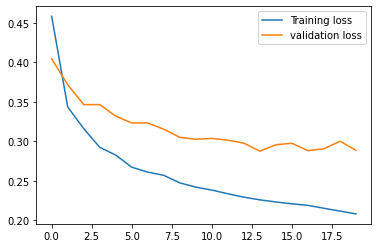

In [5]:
plt.plot(trainloss_vgg_fc, label='Training loss')
plt.plot(validationloss_vgg_fc, label='validation loss')
plt.legend()

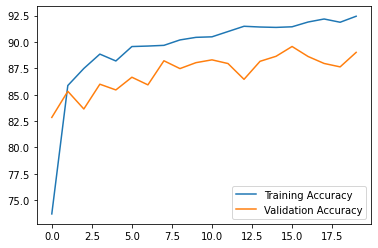

In [4]:
plt.plot(trainacc_vgg_fc, label='Training Accuracy')
plt.plot(validationacc_vgg_fc, label='Validation Accuracy')
plt.legend()

In [0]:
trainacc_vgg_fc, validationacc_vgg_fc, trainloss_vgg_fc, validationloss_vgg_fc, vgg16_1 = train(vgg16_1, 0.000005,20, validationloader, testloader ,trainacc_vgg_fc, validationacc_vgg_fc, trainloss_vgg_fc, validationloss_vgg_fc)

Epoch:  0  item:  748  total item:  1500


Epoch:  0  item:  748  total item:  1500
Epoch:  0 	Training accuracy:  88.02409444887525 	Validation accuracy:  94.72276297683773 	Training loss:  0.2902747470140457 	Validation loss:  0.17910571819543838


Epoch:  1  item:  748  total item:  1500


Epoch:  1  item:  748  total item:  1500
Epoch:  1 	Training accuracy:  88.26207584649717 	Validation accuracy:  94.72646927275169 	Training loss:  0.2902877781788508 	Validation loss:  0.1765489721298218


Epoch:  2  item:  748  total item:  1500


Epoch:  2  item:  748  total item:  1500
Epoch:  2 	Training accuracy:  88.253467466962 	Validation accuracy:  95.43872237367897 	Training loss:  0.28421455291906994 	Validation loss:  0.17318061876296997


Epoch:  3  item:  748  total item:  1500


Epoch:  3  item:  748  total item:  1500
Epoch:  3 	Training accuracy:  86.76601145137857 	Validation accuracy:  94.77934772422346 	Training loss:  0.2809301789999008 	Validation loss:  0.17967317004998526


Epoch:  4  item:  748  total item:  1500


Epoch:  4  item:  748  total item:  1500
Epoch:  4 	Training accuracy:  90.01791435536529 	Validation accuracy:  95.09553817561391 	Training loss:  0.27728077860673267 	Validation loss:  0.17256797122955322


Epoch:  5  item:  748  total item:  1500


Epoch:  5  item:  748  total item:  1500
Epoch:  5 	Training accuracy:  88.63740772371924 	Validation accuracy:  93.63793359069423 	Training loss:  0.26685135352611544 	Validation loss:  0.17972843913237255


Epoch:  6  item:  748  total item:  1500


Epoch:  6  item:  748  total item:  1500
Epoch:  6 	Training accuracy:  88.451851442728 	Validation accuracy:  95.01287652798216 	Training loss:  0.26845168765385946 	Validation loss:  0.17825352708498637


Epoch:  7  item:  748  total item:  1500


Epoch:  7  item:  748  total item:  1500
Epoch:  7 	Training accuracy:  89.35220860035089 	Validation accuracy:  93.44437938063567 	Training loss:  0.2717657512029012 	Validation loss:  0.18261803094546


Epoch:  8  item:  748  total item:  1500


Epoch:  8  item:  748  total item:  1500
Epoch:  8 	Training accuracy:  88.35217874161587 	Validation accuracy:  95.40668318152447 	Training loss:  0.2624811409711838 	Validation loss:  0.1774864447514216


Epoch:  9  item:  748  total item:  1500


Epoch:  9  item:  748  total item:  1500
Epoch:  9 	Training accuracy:  88.92159988516318 	Validation accuracy:  94.73687466270802 	Training loss:  0.2587359071572622 	Validation loss:  0.18174419808387757


Epoch:  10  item:  748  total item:  1500


Epoch:  10  item:  748  total item:  1500
Epoch:  10 	Training accuracy:  88.03486982565866 	Validation accuracy:  94.89850073060737 	Training loss:  0.2573215580383937 	Validation loss:  0.17510321658849717


Epoch:  11  item:  748  total item:  1500


Epoch:  11  item:  748  total item:  1500
Epoch:  11 	Training accuracy:  90.42438551189933 	Validation accuracy:  94.69551640796188 	Training loss:  0.25316819496949516 	Validation loss:  0.17248137108484904


Epoch:  12  item:  748  total item:  1500


Epoch:  12  item:  748  total item:  1500
Epoch:  12 	Training accuracy:  91.84777539722275 	Validation accuracy:  94.60117737493779 	Training loss:  0.24368567621707915 	Validation loss:  0.18072719752788544


Epoch:  13  item:  748  total item:  1500


Epoch:  13  item:  748  total item:  1500
Epoch:  13 	Training accuracy:  88.31991167818035 	Validation accuracy:  94.56099674026969 	Training loss:  0.2524902350505193 	Validation loss:  0.17582925570011138


Epoch:  14  item:  748  total item:  1500


Epoch:  14  item:  748  total item:  1500
Epoch:  14 	Training accuracy:  89.50612986534355 	Validation accuracy:  95.84757354051521 	Training loss:  0.24321702833970388 	Validation loss:  0.17163264840841294


Epoch:  15  item:  748  total item:  1500


Epoch:  15  item:  748  total item:  1500
Epoch:  15 	Training accuracy:  89.24180213817898 	Validation accuracy:  94.46072526788824 	Training loss:  0.24633464245001474 	Validation loss:  0.1849728573958079


Epoch:  16  item:  748  total item:  1500


Epoch:  16  item:  748  total item:  1500
Epoch:  16 	Training accuracy:  91.25922030892671 	Validation accuracy:  94.78147028350091 	Training loss:  0.2413889478246371 	Validation loss:  0.17165830133358637


Epoch:  17  item:  748  total item:  1500


Epoch:  17  item:  748  total item:  1500
Epoch:  17 	Training accuracy:  90.03008118751303 	Validation accuracy:  94.55616174589575 	Training loss:  0.2435168330669403 	Validation loss:  0.17764781137307484


Epoch:  18  item:  748  total item:  1500


Epoch:  18  item:  748  total item:  1500
Epoch:  18 	Training accuracy:  91.87762025916237 	Validation accuracy:  94.74146028192634 	Training loss:  0.23723675696055094 	Validation loss:  0.17411269728342693


Epoch:  19  item:  748  total item:  1500


Epoch:  19  item:  748  total item:  1500
Epoch:  19 	Training accuracy:  89.64962570241876 	Validation accuracy:  95.6360983329772 	Training loss:  0.23895592407385507 	Validation loss:  0.18048743120829264


In [0]:
torch.save(vgg16_1.state_dict() ,'/content/drive/My Drive/Data/MSDS/Semester2/Deeplearning/assignment5_2/vgg_FC_Only.pth')

In [0]:
nb_classes = 2

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(testloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = vgg16_1(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[555.,  60.],
        [ 22., 863.]])


In [0]:
trainacc_vgg_fc, validationacc_vgg_fc, trainloss_vgg_fc, validationloss_vgg_fc = [], [], [], []

In [0]:
nb_classes = 2

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(validationloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = vgg16_1(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
print(confusion_matrix)

tensor([[544.,  71.],
        [ 68., 817.]])


#### RESNET

In [0]:
resnet18_1 = models.resnet18(pretrained=True)

In [0]:
for parm in resnet18_1.parameters():
  parm.requires_grad = False

In [0]:
resnet18_1.fc = nn.Sequential(nn.Linear(in_features=512, out_features=210, bias=True),  nn.ReLU(inplace=True), nn.Dropout(p=0.5, inplace=False), nn.Linear(in_features=210, out_features=2, bias=True))

In [0]:
resnet18_1

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
# for parm in resnet18_1.parameters():
#   print(parm.requires_grad)

In [0]:
# resnet18.load_state_dict(torch.load('/content/drive/My Drive/Data/MSDS/Semester2/Deeplearning/assignment5/resnet18_FC_Only.pth', map_location=torch.device('cpu')))

In [0]:
trainacc_resnet18_1, validationacc_resnet18_1, trainloss_resnet18_1, validationloss_resnet18_1 = [], [], [], []

In [0]:
trainacc_resnet18_1, validationacc_resnet18_1, trainloss_resnet18_1, validationloss_resnet18_1, resnet18_1 = train(resnet18_1, 0.0001 ,20, trainloader, validationloader, trainacc_resnet18_1, validationacc_resnet18_1, trainloss_resnet18_1, validationloss_resnet18_1)

Epoch:  0  item:  5984  total item:  12000


Epoch:  0  item:  644  total item:  1500
Epoch:  0 	Training accuracy:  59.02619016216603 	Validation accuracy:  71.49730480637203 	Training loss:  0.623431316057841 	Validation loss:  0.5861925582885742


Epoch:  1  item:  5984  total item:  12000


Epoch:  1  item:  644  total item:  1500
Epoch:  1 	Training accuracy:  75.82946616616812 	Validation accuracy:  80.39762659426147 	Training loss:  0.5304991385142008 	Validation loss:  0.5321040585835775


Epoch:  2  item:  5984  total item:  12000


Epoch:  2  item:  644  total item:  1500
Epoch:  2 	Training accuracy:  80.21701272306959 	Validation accuracy:  80.3162025382329 	Training loss:  0.4798748588562012 	Validation loss:  0.4961317329406738


Epoch:  3  item:  5984  total item:  12000


Epoch:  3  item:  644  total item:  1500
Epoch:  3 	Training accuracy:  82.01058089082558 	Validation accuracy:  81.47932025634186 	Training loss:  0.4424109705289205 	Validation loss:  0.474275873819987


Epoch:  4  item:  5984  total item:  12000


Epoch:  4  item:  644  total item:  1500
Epoch:  4 	Training accuracy:  83.32276646443766 	Validation accuracy:  83.62152835838377 	Training loss:  0.42105694913864133 	Validation loss:  0.44619782257080076


Epoch:  5  item:  5984  total item:  12000


Epoch:  5  item:  644  total item:  1500
Epoch:  5 	Training accuracy:  83.47201472329522 	Validation accuracy:  83.39805114773553 	Training loss:  0.40618114455540977 	Validation loss:  0.43836317825317384


Epoch:  6  item:  5984  total item:  12000


Epoch:  6  item:  644  total item:  1500
Epoch:  6 	Training accuracy:  83.59921437795364 	Validation accuracy:  84.59233471135236 	Training loss:  0.39187885268529254 	Validation loss:  0.42656163787841794


Epoch:  7  item:  5984  total item:  12000


Epoch:  7  item:  644  total item:  1500
Epoch:  7 	Training accuracy:  84.53774253624839 	Validation accuracy:  83.345351586878 	Training loss:  0.38320663579305014 	Validation loss:  0.4251779123942057


Epoch:  8  item:  5984  total item:  12000


Epoch:  8  item:  644  total item:  1500
Epoch:  8 	Training accuracy:  84.71207786807754 	Validation accuracy:  83.44920844179775 	Training loss:  0.37217644302050273 	Validation loss:  0.42295035807291664


Epoch:  9  item:  5984  total item:  12000


Epoch:  9  item:  644  total item:  1500
Epoch:  9 	Training accuracy:  84.60295897471634 	Validation accuracy:  85.76348091251563 	Training loss:  0.37059973057111106 	Validation loss:  0.41995137786865233


Epoch:  10  item:  5984  total item:  12000


Epoch:  10  item:  644  total item:  1500
Epoch:  10 	Training accuracy:  85.29122126521291 	Validation accuracy:  85.54741828834032 	Training loss:  0.36392424631118775 	Validation loss:  0.4049815800984701


Epoch:  11  item:  5984  total item:  12000


Epoch:  11  item:  644  total item:  1500
Epoch:  11 	Training accuracy:  85.89850233168674 	Validation accuracy:  85.21613569349091 	Training loss:  0.35840988739331564 	Validation loss:  0.3998009376525879


Epoch:  12  item:  5984  total item:  12000


Epoch:  12  item:  644  total item:  1500
Epoch:  12 	Training accuracy:  86.06088137724223 	Validation accuracy:  82.59688472598131 	Training loss:  0.3505351382891337 	Validation loss:  0.410857546488444


Epoch:  13  item:  5984  total item:  12000


Epoch:  13  item:  644  total item:  1500
Epoch:  13 	Training accuracy:  86.39390488045004 	Validation accuracy:  86.00239819012046 	Training loss:  0.35097542333602905 	Validation loss:  0.3922934824625651


Epoch:  14  item:  5984  total item:  12000


Epoch:  14  item:  644  total item:  1500
Epoch:  14 	Training accuracy:  86.14043256256929 	Validation accuracy:  83.23608494072795 	Training loss:  0.3455489195982615 	Validation loss:  0.3993851547241211


Epoch:  15  item:  5984  total item:  12000


Epoch:  15  item:  644  total item:  1500
Epoch:  15 	Training accuracy:  87.19018604545064 	Validation accuracy:  85.20449799833733 	Training loss:  0.3426186004479726 	Validation loss:  0.40187499872843424


Epoch:  16  item:  5984  total item:  12000


Epoch:  16  item:  644  total item:  1500
Epoch:  16 	Training accuracy:  86.0172347930879 	Validation accuracy:  85.5528769129028 	Training loss:  0.33943543330828346 	Validation loss:  0.39233158620198566


Epoch:  17  item:  5984  total item:  12000


Epoch:  17  item:  644  total item:  1500
Epoch:  17 	Training accuracy:  86.42513185399206 	Validation accuracy:  87.06833178977487 	Training loss:  0.3357050474484762 	Validation loss:  0.38894312795003255


Epoch:  18  item:  5984  total item:  12000


Epoch:  18  item:  644  total item:  1500
Epoch:  18 	Training accuracy:  87.02278112005445 	Validation accuracy:  87.12541109662038 	Training loss:  0.3360815239747365 	Validation loss:  0.38103427886962893


Epoch:  19  item:  5984  total item:  12000


Epoch:  19  item:  644  total item:  1500
Epoch:  19 	Training accuracy:  87.03598335410722 	Validation accuracy:  86.65063580479337 	Training loss:  0.33598211932182315 	Validation loss:  0.3847880827585856


In [0]:
trainacc_resnet18_1, validationacc_resnet18_1, trainloss_resnet18_1, validationloss_resnet18_1, resnet18_1 = train(resnet18_1, 0.0001, 5, trainloader, validationloader,  trainacc_resnet18_1, validationacc_resnet18_1, trainloss_resnet18_1, validationloss_resnet18_1)

Epoch:  0  item:  5984  total item:  12000


Epoch:  0  item:  644  total item:  1500
Epoch:  0 	Training accuracy:  87.20195830427065 	Validation accuracy:  85.20305671410745 	Training loss:  0.3301327121257782 	Validation loss:  0.3900489082336426


Epoch:  1  item:  5984  total item:  12000


Epoch:  1  item:  644  total item:  1500
Epoch:  1 	Training accuracy:  86.46578544672842 	Validation accuracy:  85.67396638964006 	Training loss:  0.32709191950162253 	Validation loss:  0.38249809583028155


Epoch:  2  item:  5984  total item:  12000


Epoch:  2  item:  644  total item:  1500
Epoch:  2 	Training accuracy:  86.48541511503483 	Validation accuracy:  86.84708223052827 	Training loss:  0.3266346527735392 	Validation loss:  0.38057475407918295


Epoch:  3  item:  5984  total item:  12000


Epoch:  3  item:  644  total item:  1500
Epoch:  3 	Training accuracy:  86.79926074914208 	Validation accuracy:  84.85295230748572 	Training loss:  0.3255253965059916 	Validation loss:  0.3758689238230387


Epoch:  4  item:  5984  total item:  12000


Epoch:  4  item:  644  total item:  1500
Epoch:  4 	Training accuracy:  87.33187978703886 	Validation accuracy:  85.68934673467302 	Training loss:  0.3201571218172709 	Validation loss:  0.37323343722025554


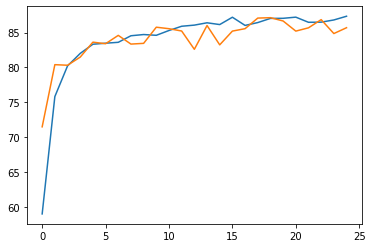

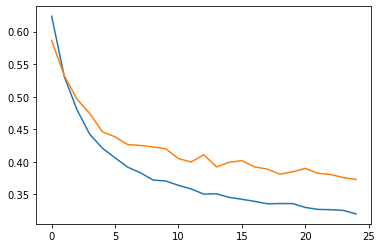

In [0]:
plt.plot(trainacc_resnet18_1, label='Training Accuracy') 
plt.plot(validationacc_resnet18_1, label='Validation Accuracy')
plt.legend()
plt.show()
plt.plot(trainloss_resnet18_1, label='Training loss') 
plt.plot(validationloss_resnet18_1, label='Validation loss')
plt.legend()

In [0]:
trainacc_resnet18_1, validationacc_resnet18_1, trainloss_resnet18_1, validationloss_resnet18_1, resnet18_1 = train(resnet18_1, 0.0001, 5, validationloader, testloader ,trainacc_resnet18_1, validationacc_resnet18_1, trainloss_resnet18_1, validationloss_resnet18_1)

Epoch:  0  item:  644  total item:  1500


Epoch:  0  item:  644  total item:  1500
Epoch:  0 	Training accuracy:  86.41423906381479 	Validation accuracy:  91.5187291787561 	Training loss:  0.3864482955932617 	Validation loss:  0.25446096356709796


Epoch:  1  item:  644  total item:  1500


Epoch:  1  item:  644  total item:  1500
Epoch:  1 	Training accuracy:  86.08040461157823 	Validation accuracy:  94.58107322280678 	Training loss:  0.38309974733988444 	Validation loss:  0.2646974048614502


Epoch:  2  item:  644  total item:  1500


Epoch:  2  item:  644  total item:  1500
Epoch:  2 	Training accuracy:  85.08772449532688 	Validation accuracy:  93.65840835723306 	Training loss:  0.38089623260498046 	Validation loss:  0.25986735661824545


Epoch:  3  item:  644  total item:  1500


Epoch:  3  item:  644  total item:  1500
Epoch:  3 	Training accuracy:  86.82541021319706 	Validation accuracy:  93.55644218680519 	Training loss:  0.3897869313557943 	Validation loss:  0.2519902426401774


Epoch:  4  item:  644  total item:  1500


Epoch:  4  item:  644  total item:  1500
Epoch:  4 	Training accuracy:  86.33658322859145 	Validation accuracy:  93.7278401078349 	Training loss:  0.38084018580118817 	Validation loss:  0.26172390174865723


In [0]:
torch.save(resnet18_1.state_dict() ,'/content/drive/My Drive/Data/MSDS/Semester2/Deeplearning/assignment5_2/resnet18_FC_Only.pth')

VGG 16 last layer gradients = True

In [0]:
# # Load the pretrained model from pytorch
vgg16_2 = models.vgg16(pretrained=True)
# print(vgg16)
# print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

In [0]:
for parm in vgg16.parameters():
  parm.requires_grad = False

# for parm in vgg16.parameters():
#   print(parm.requires_grad)

In [0]:
num_features = vgg16_2.classifier[0].in_features
vgg16_2.classifier = vgg16_2.classifier[:4]
vgg16_2.classifier[0] = nn.Linear(num_features, 210)
vgg16_2.classifier[3] = nn.Linear(210, len(class_names))
# vgg16.load_state_dict(torch.load('/content/drive/My Drive/Data/MSDS/Semester2/Deeplearning/assignment5/vgg16_feature_1.pth', map_location=torch.device('cpu')))
# vgg16

In [0]:
for parm in vgg16.features[30].parameters():
  parm.requires_grad = True

for parm in vgg16.features[29].parameters():
  parm.requires_grad = True

for parm in vgg16.features[28].parameters():
  parm.requires_grad = True

# for parm in vgg16.features[27].parameters():
#   parm.requires_grad = True

# for parm in vgg16.features[26].parameters():
#   parm.requires_grad = True

# for parm in vgg16.features[25].parameters():
#   parm.requires_grad = True

In [0]:
trainacc_vgg_fc2, validationacc_vgg_fc2, trainloss_vgg_fc2, validationloss_vgg_fc2 = [], [], [], []

In [0]:
trainacc_vgg_fc2, validationacc_vgg_fc2, trainloss_vgg_fc2, validationloss_vgg_fc2, vgg16_2 = train(vgg16_2, 0.000005,20, trainloader, validationloader, trainacc_vgg_fc2, validationacc_vgg_fc2, trainloss_vgg_fc2, validationloss_vgg_fc2)

Epoch:  0  item:  11992  total item:  12000


Epoch:  0  item:  748  total item:  1500
Epoch:  0 	Training accuracy:  87.91229649425911 	Validation accuracy:  86.92311589012425 	Training loss:  0.3039655877997478 	Validation loss:  0.32498529787858327


Epoch:  1  item:  11992  total item:  12000


Epoch:  1  item:  748  total item:  1500
Epoch:  1 	Training accuracy:  88.76851080653061 	Validation accuracy:  86.75719922785116 	Training loss:  0.28451190945506094 	Validation loss:  0.31041784993807475


Epoch:  2  item:  11992  total item:  12000


Epoch:  2  item:  748  total item:  1500
Epoch:  2 	Training accuracy:  89.8833210326041 	Validation accuracy:  89.29549998630463 	Training loss:  0.27208991145342587 	Validation loss:  0.3072243536710739


Epoch:  3  item:  11992  total item:  12000


Epoch:  3  item:  748  total item:  1500
Epoch:  3 	Training accuracy:  89.95048221691555 	Validation accuracy:  88.17332681799618 	Training loss:  0.26098824504762885 	Validation loss:  0.30133892464637757


Epoch:  4  item:  11992  total item:  12000


Epoch:  4  item:  748  total item:  1500
Epoch:  4 	Training accuracy:  90.58953348081963 	Validation accuracy:  87.05361760069984 	Training loss:  0.2503366791506608 	Validation loss:  0.29243835882345837


Epoch:  5  item:  11992  total item:  12000


Epoch:  5  item:  748  total item:  1500
Epoch:  5 	Training accuracy:  90.54621640475953 	Validation accuracy:  87.16500767453158 	Training loss:  0.2431256357903282 	Validation loss:  0.29358672324816387


Epoch:  6  item:  11992  total item:  12000


Epoch:  6  item:  748  total item:  1500
Epoch:  6 	Training accuracy:  90.73935868958937 	Validation accuracy:  89.19448205105574 	Training loss:  0.23778635440518459 	Validation loss:  0.2868814167181651


Epoch:  7  item:  11992  total item:  12000


Epoch:  7  item:  748  total item:  1500
Epoch:  7 	Training accuracy:  91.32636267780994 	Validation accuracy:  87.87194013781489 	Training loss:  0.23244083693126838 	Validation loss:  0.2857728351950645


Epoch:  8  item:  11992  total item:  12000


Epoch:  8  item:  748  total item:  1500
Epoch:  8 	Training accuracy:  91.32216814575986 	Validation accuracy:  88.58992504847843 	Training loss:  0.2270705304046472 	Validation loss:  0.2773059304753939


Epoch:  9  item:  11992  total item:  12000


Epoch:  9  item:  748  total item:  1500
Epoch:  9 	Training accuracy:  91.529264898843 	Validation accuracy:  89.33211516871792 	Training loss:  0.2233660616738101 	Validation loss:  0.2822354904015859


Epoch:  10  item:  11992  total item:  12000


Epoch:  10  item:  748  total item:  1500
Epoch:  10 	Training accuracy:  91.72098477873196 	Validation accuracy:  89.06873026531414 	Training loss:  0.21908522332459687 	Validation loss:  0.2881245035529137


Epoch:  11  item:  11992  total item:  12000


Epoch:  11  item:  748  total item:  1500
Epoch:  11 	Training accuracy:  91.70358028116996 	Validation accuracy:  88.96080592609546 	Training loss:  0.2159318813458085 	Validation loss:  0.28111297204097113


Epoch:  12  item:  11992  total item:  12000


Epoch:  12  item:  748  total item:  1500
Epoch:  12 	Training accuracy:  92.0782893856937 	Validation accuracy:  88.6860388211778 	Training loss:  0.2121476788048943 	Validation loss:  0.2787561288873355


Epoch:  13  item:  11992  total item:  12000


Epoch:  13  item:  748  total item:  1500
Epoch:  13 	Training accuracy:  92.07263121328785 	Validation accuracy:  88.41943089622706 	Training loss:  0.2091060263539354 	Validation loss:  0.27525404542684556


Epoch:  14  item:  11992  total item:  12000


Epoch:  14  item:  748  total item:  1500
Epoch:  14 	Training accuracy:  92.78907407808174 	Validation accuracy:  87.51408254568128 	Training loss:  0.2048467683767279 	Validation loss:  0.27906382125616075


Epoch:  15  item:  11992  total item:  12000


Epoch:  15  item:  748  total item:  1500
Epoch:  15 	Training accuracy:  92.18290497630576 	Validation accuracy:  87.60407258471646 	Training loss:  0.20275943785657485 	Validation loss:  0.2805423830747604


Epoch:  16  item:  11992  total item:  12000


Epoch:  16  item:  748  total item:  1500
Epoch:  16 	Training accuracy:  92.33542978896295 	Validation accuracy:  87.67780560630925 	Training loss:  0.1999929204285145 	Validation loss:  0.2699798067609469


Epoch:  17  item:  11992  total item:  12000


Epoch:  17  item:  748  total item:  1500
Epoch:  17 	Training accuracy:  91.99092961023182 	Validation accuracy:  88.76492208176178 	Training loss:  0.19887106876571972 	Validation loss:  0.27025422672430677


Epoch:  18  item:  11992  total item:  12000


Epoch:  18  item:  748  total item:  1500
Epoch:  18 	Training accuracy:  92.63023522746496 	Validation accuracy:  90.0965765846678 	Training loss:  0.1948386913339297 	Validation loss:  0.27206296237309774


Epoch:  19  item:  11992  total item:  12000


Epoch:  19  item:  748  total item:  1500
Epoch:  19 	Training accuracy:  92.85875406350054 	Validation accuracy:  88.30566158398369 	Training loss:  0.1922997809102138 	Validation loss:  0.2759367618759473


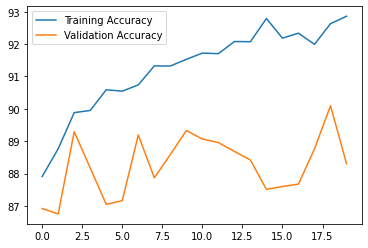

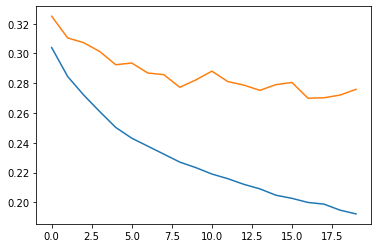

In [0]:
plt.plot(trainacc_vgg_fc2, label= 'Training Accuracy')
plt.plot(validationacc_vgg_fc2, label = 'Validation Accuracy')
plt.legend()
plt.show()
plt.plot(trainloss_vgg_fc2, label= 'Training loss')
plt.plot(validationloss_vgg_fc2, label = 'Validation loss')

In [0]:
nb_classes = 2

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(testloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = vgg16_2(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[562.,  53.],
        [ 26., 859.]])


In [0]:
nb_classes = 2

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(validationloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = vgg16_2(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[530.,  85.],
        [ 80., 805.]])


In [0]:
torch.save(vgg16.state_dict() ,'/content/drive/My Drive/Data/MSDS/Semester2/Deeplearning/assignment5/vgg16_feature_1.pth')

VGG 16 all layers gradients = True

In [0]:
# Load the pretrained model from pytorch
vgg16_entire = models.vgg16(pretrained=True)
# print(vgg16)
# print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

In [0]:
for parm in vgg16_entire.parameters():
  parm.requires_grad = True

In [0]:
num_features = vgg16_entire.classifier[0].in_features
vgg16_entire.classifier = vgg16_entire.classifier[:4]
vgg16_entire.classifier[0] = nn.Linear(num_features, 210)
vgg16_entire.classifier[3] = nn.Linear(210, len(class_names))
# vgg16.load_state_dict(torch.load('/content/drive/My Drive/Data/MSDS/Semester2/Deeplearning/assignment5/vgg16_entire.pth', map_location=torch.device('cpu')))
# vgg16

In [0]:
# for parm in vgg16.parameters():
#   print(parm.requires_grad)

In [0]:
trainacc_vgg_entire, validationacc_vgg_entire, trainloss_vgg_entire, validationloss_vgg_entire = [], [], [], []

In [0]:
trainacc_vgg_entire, validationacc_vgg_entire, trainloss_vgg_entire, validationloss_vgg_entire, vgg16_entire = train(vgg16_entire, 0.000005,20, trainloader, validationloader, trainacc_vgg_entire, validationacc_vgg_entire, trainloss_vgg_entire, validationloss_vgg_entire)

Epoch:  0  item:  5984  total item:  12000


Epoch:  0  item:  644  total item:  1500
Epoch:  0 	Training accuracy:  56.357084404234676 	Validation accuracy:  73.60725635659165 	Training loss:  0.6305187864303589 	Validation loss:  0.5958406753540039


Epoch:  1  item:  5984  total item:  12000


Epoch:  1  item:  644  total item:  1500
Epoch:  1 	Training accuracy:  74.84732079808965 	Validation accuracy:  80.00709692618247 	Training loss:  0.5295832540194193 	Validation loss:  0.5241129976908366


Epoch:  2  item:  5984  total item:  12000


Epoch:  2  item:  644  total item:  1500
Epoch:  2 	Training accuracy:  82.01370177464787 	Validation accuracy:  81.68354047253406 	Training loss:  0.46152532641092936 	Validation loss:  0.48340402348836264


Epoch:  3  item:  5984  total item:  12000


Epoch:  3  item:  644  total item:  1500
Epoch:  3 	Training accuracy:  84.23601982299593 	Validation accuracy:  84.91406190013353 	Training loss:  0.41784121131896973 	Validation loss:  0.4421509780883789


Epoch:  4  item:  5984  total item:  12000


Epoch:  4  item:  644  total item:  1500
Epoch:  4 	Training accuracy:  85.30676697290795 	Validation accuracy:  84.09725002351709 	Training loss:  0.38569112769762676 	Validation loss:  0.429087038675944


Epoch:  5  item:  5984  total item:  12000


Epoch:  5  item:  644  total item:  1500
Epoch:  5 	Training accuracy:  85.35712534544446 	Validation accuracy:  83.63657070746764 	Training loss:  0.36546999955177306 	Validation loss:  0.4190406913757324


Epoch:  6  item:  5984  total item:  12000


Epoch:  6  item:  644  total item:  1500
Epoch:  6 	Training accuracy:  86.29478033815829 	Validation accuracy:  86.33577010839326 	Training loss:  0.3476766233444214 	Validation loss:  0.4040223344167074


Epoch:  7  item:  5984  total item:  12000


Epoch:  7  item:  644  total item:  1500
Epoch:  7 	Training accuracy:  87.54319541650898 	Validation accuracy:  84.83726234175481 	Training loss:  0.33247465880711874 	Validation loss:  0.39370413780212404


Epoch:  8  item:  5984  total item:  12000


Epoch:  8  item:  644  total item:  1500
Epoch:  8 	Training accuracy:  87.43004815873242 	Validation accuracy:  85.8369139064806 	Training loss:  0.3237132987976074 	Validation loss:  0.38798537190755206


Epoch:  9  item:  5984  total item:  12000


Epoch:  9  item:  644  total item:  1500
Epoch:  9 	Training accuracy:  87.82115436000097 	Validation accuracy:  87.38431282206075 	Training loss:  0.3158665160338084 	Validation loss:  0.37481485430399575


Epoch:  10  item:  5984  total item:  12000


Epoch:  10  item:  644  total item:  1500
Epoch:  10 	Training accuracy:  88.61614895338474 	Validation accuracy:  85.96423397686954 	Training loss:  0.3047261911233266 	Validation loss:  0.3550878448486328


Epoch:  11  item:  5984  total item:  12000


Epoch:  11  item:  644  total item:  1500
Epoch:  11 	Training accuracy:  88.46719003363751 	Validation accuracy:  87.12842602306982 	Training loss:  0.29949253424008687 	Validation loss:  0.3572221457163493


Epoch:  12  item:  5984  total item:  12000


Epoch:  12  item:  644  total item:  1500
Epoch:  12 	Training accuracy:  88.86662538800954 	Validation accuracy:  86.86758259175004 	Training loss:  0.2948277627627055 	Validation loss:  0.3669247964223226


Epoch:  13  item:  5984  total item:  12000


Epoch:  13  item:  644  total item:  1500
Epoch:  13 	Training accuracy:  89.12888810562666 	Validation accuracy:  86.02364757202135 	Training loss:  0.2852791946729024 	Validation loss:  0.3487166398366292


Epoch:  14  item:  5984  total item:  12000


Epoch:  14  item:  644  total item:  1500
Epoch:  14 	Training accuracy:  89.27244053942985 	Validation accuracy:  89.17716245129562 	Training loss:  0.27873741738001506 	Validation loss:  0.33897442213694257


Epoch:  15  item:  5984  total item:  12000


Epoch:  15  item:  644  total item:  1500
Epoch:  15 	Training accuracy:  89.09650683635134 	Validation accuracy:  87.37764983265687 	Training loss:  0.27526954738299053 	Validation loss:  0.346183713277181


Epoch:  16  item:  5984  total item:  12000


Epoch:  16  item:  644  total item:  1500
Epoch:  16 	Training accuracy:  90.06565355159026 	Validation accuracy:  88.80453178631592 	Training loss:  0.2714292359749476 	Validation loss:  0.3405840644836426


Epoch:  17  item:  5984  total item:  12000


Epoch:  17  item:  644  total item:  1500
Epoch:  17 	Training accuracy:  90.1679599317807 	Validation accuracy:  89.03752843375298 	Training loss:  0.26143685726324717 	Validation loss:  0.3360010445912679


Epoch:  18  item:  3968  total item:  12000

In [0]:
plt.plot(trainacc_vgg_entire, label='Training Accuracy')
plt.plot(validationacc_vgg_entire, label='Validation Accuracy')
plt.legend()
plt.show()
plt.plot(trainloss_vgg_entire, label='Training loss')
plt.plot(validationloss_vgg_entire, label='Validation loss')

In [0]:
torch.save(vgg16_entire.state_dict() ,'/content/drive/My Drive/Data/MSDS/Semester2/Deeplearning/assignment5_2/vgg16_entire.pth')

In [0]:
trainacc_vgg_entire, validationacc_vgg_entire, trainloss_vgg_entire, validationloss_vgg_entire, vgg16_entire = train(vgg16_entire, 0.000005,2, validationloader, testloader, trainacc_vgg_entire, validationacc_vgg_entire, trainloss_vgg_entire, validationloss_vgg_entire)

In [0]:
Epochs = 1
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.000001, momentum=0.9)

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)
vgg16.train()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
vgg16_entire_loss = []

In [0]:
Epochs = 10
for epoch in range(Epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data.item()))
    vgg16_entire_loss.append(running_loss/(len(trainloader.dataset)/64))
print('Finished Training')


Finished Training


In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in validationloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the validation images: %d %%' % (100 * correct / total))

Accuracy of the network on the validation images: 89 %


In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in validationloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the validation images: %d %%' % (100 * correct / total))

Accuracy of the network on the validation images: 89 %


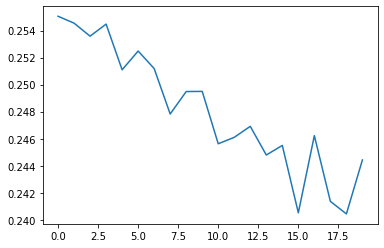

In [0]:
plt.plot(vgg16_entire_loss)

In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 94 %


In [0]:
Epochs = 10
for epoch in range(Epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    pbar = tqdm(enumerate(validationloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(validationloader.dataset),
                100. * i / len(validationloader),
                loss.data.item()))

print('Finished Training')

Train Epoch: 0 [748/1500 (99%)]	Loss: 0.317022: : 188it [00:30,  6.15it/s]
Train Epoch: 1 [748/1500 (99%)]	Loss: 0.157427: : 188it [00:30,  6.18it/s]
Train Epoch: 2 [748/1500 (99%)]	Loss: 0.076562: : 188it [00:30,  6.17it/s]
Train Epoch: 3 [748/1500 (99%)]	Loss: 0.537059: : 188it [00:30,  6.17it/s]
Train Epoch: 4 [748/1500 (99%)]	Loss: 0.148832: : 188it [00:30,  6.13it/s]
Train Epoch: 5 [748/1500 (99%)]	Loss: 0.256307: : 188it [00:30,  6.17it/s]
Train Epoch: 6 [748/1500 (99%)]	Loss: 0.341527: : 188it [00:30,  6.17it/s]
Train Epoch: 7 [748/1500 (99%)]	Loss: 0.696156: : 188it [00:30,  6.16it/s]
Train Epoch: 8 [748/1500 (99%)]	Loss: 0.088395: : 188it [00:30,  6.15it/s]
Train Epoch: 9 [748/1500 (99%)]	Loss: 0.286303: : 188it [00:30,  6.19it/s]

Finished Training


In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 94 %


In [0]:
nb_classes = 2

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(testloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = vgg16(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[558.,  57.],
        [ 32., 853.]])


In [0]:
nb_classes = 2

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(validationloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = vgg16(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[533.,  82.],
        [ 92., 793.]])


In [0]:
torch.save(vgg16.state_dict() ,'/content/drive/My Drive/Data/MSDS/Semester2/Deeplearning/assignment5/vgg16_entire.pth')

Task 2 Resnet18 1 layer 

In [0]:
resnet18_2 = models.resnet18(pretrained=True)

In [0]:
for parm in resnet18_2.parameters():
  parm.requires_grad = False

In [0]:
for parm in resnet18_2.layer4.parameters():
  parm.requires_grad = True

In [0]:
# for parm in resnet18_2.parameters():
#   print(parm.requires_grad)

In [0]:
resnet18_entire.fc = nn.Sequential(nn.Linear(in_features=512, out_features=210, bias=True),  nn.ReLU(inplace=True), nn.Dropout(p=0.5, inplace=False), nn.Linear(in_features=210, out_features=2, bias=True))

In [0]:
trainacc_resnet18_2, validationacc_resnet18_2, trainloss_resnet18_2, validationloss_resnet18_2 = [], [], [], []

In [0]:
trainacc_resnet18_2, validationacc_resnet18_2, trainloss_resnet18_2, validationloss_resnet18_2, resnet18_2 = train(resnet18_2, 0.0001 ,20, trainloader, validationloader, trainacc_resnet18_2, validationacc_resnet18_2, trainloss_resnet18_2, validationloss_resnet18_2)

Epoch:  0  item:  5984  total item:  12000


Epoch:  0  item:  644  total item:  1500
Epoch:  0 	Training accuracy:  4.75266221853058 	Validation accuracy:  48.90817041175474 	Training loss:  6.384659725189209 	Validation loss:  4.658909291585286


Epoch:  1  item:  5984  total item:  12000


Epoch:  1  item:  644  total item:  1500
Epoch:  1 	Training accuracy:  61.95531566474964 	Validation accuracy:  73.71330408998378 	Training loss:  3.160718579610189 	Validation loss:  2.987776824951172


Epoch:  2  item:  5984  total item:  12000


Epoch:  2  item:  644  total item:  1500
Epoch:  2 	Training accuracy:  80.63420207199158 	Validation accuracy:  84.74444566202955 	Training loss:  1.9894212398529052 	Validation loss:  2.2098584747314454


Epoch:  3  item:  5984  total item:  12000


Epoch:  3  item:  644  total item:  1500
Epoch:  3 	Training accuracy:  87.223723323223 	Validation accuracy:  86.38530684864311 	Training loss:  1.4605265417098998 	Validation loss:  1.8208341166178386


Epoch:  4  item:  5984  total item:  12000


Epoch:  4  item:  644  total item:  1500
Epoch:  4 	Training accuracy:  89.39318336701207 	Validation accuracy:  89.07070411974819 	Training loss:  1.1757360016504923 	Validation loss:  1.5236616668701173


Epoch:  5  item:  5984  total item:  12000


Epoch:  5  item:  644  total item:  1500
Epoch:  5 	Training accuracy:  90.79725561949215 	Validation accuracy:  88.20885052517815 	Training loss:  1.0099887035687765 	Validation loss:  1.386473637898763


Epoch:  6  item:  5984  total item:  12000


Epoch:  6  item:  644  total item:  1500
Epoch:  6 	Training accuracy:  91.28495946534329 	Validation accuracy:  89.29370773280154 	Training loss:  0.8740933295090993 	Validation loss:  1.2782373809814453


Epoch:  7  item:  5984  total item:  12000


Epoch:  7  item:  644  total item:  1500
Epoch:  7 	Training accuracy:  91.59570485151457 	Validation accuracy:  89.85069846553687 	Training loss:  0.789183286190033 	Validation loss:  1.190742451985677


Epoch:  8  item:  5984  total item:  12000


Epoch:  8  item:  644  total item:  1500
Epoch:  8 	Training accuracy:  91.56043258441798 	Validation accuracy:  90.07808782764127 	Training loss:  0.7194458756446839 	Validation loss:  1.095246031443278


Epoch:  9  item:  5984  total item:  12000


Epoch:  9  item:  644  total item:  1500
Epoch:  9 	Training accuracy:  92.16427068585969 	Validation accuracy:  91.21030947514669 	Training loss:  0.6520694789091745 	Validation loss:  1.0509036401112875


Epoch:  10  item:  5984  total item:  12000


Epoch:  10  item:  644  total item:  1500
Epoch:  10 	Training accuracy:  91.8260472292596 	Validation accuracy:  91.08473208315641 	Training loss:  0.623388021628062 	Validation loss:  1.037441551208496


Epoch:  11  item:  5984  total item:  12000


Epoch:  11  item:  644  total item:  1500
Epoch:  11 	Training accuracy:  92.21830902755283 	Validation accuracy:  91.83020146907032 	Training loss:  0.5657836247285207 	Validation loss:  0.9302780405680339


Epoch:  12  item:  5984  total item:  12000


Epoch:  12  item:  644  total item:  1500
Epoch:  12 	Training accuracy:  92.98627127769181 	Validation accuracy:  91.12593457819756 	Training loss:  0.5276626629829406 	Validation loss:  0.9106806195576985


Epoch:  13  item:  5984  total item:  12000


Epoch:  13  item:  644  total item:  1500
Epoch:  13 	Training accuracy:  93.05543350023987 	Validation accuracy:  92.9389491830749 	Training loss:  0.49540041414896646 	Validation loss:  0.9056228523254395


Epoch:  14  item:  5984  total item:  12000


Epoch:  14  item:  644  total item:  1500
Epoch:  14 	Training accuracy:  92.8949265237002 	Validation accuracy:  90.92283051455257 	Training loss:  0.47828719985485074 	Validation loss:  0.8331327095031739


Epoch:  15  item:  5984  total item:  12000


Epoch:  15  item:  644  total item:  1500
Epoch:  15 	Training accuracy:  93.2564979061799 	Validation accuracy:  92.54067966110756 	Training loss:  0.4489672393401464 	Validation loss:  0.8794690469106038


Epoch:  16  item:  5984  total item:  12000


Epoch:  16  item:  644  total item:  1500
Epoch:  16 	Training accuracy:  93.40432124801615 	Validation accuracy:  90.22544268566321 	Training loss:  0.4235049625237783 	Validation loss:  0.8036491673787435


Epoch:  17  item:  5984  total item:  12000


Epoch:  17  item:  644  total item:  1500
Epoch:  17 	Training accuracy:  93.35626794519632 	Validation accuracy:  91.64789514747629 	Training loss:  0.4110038922230403 	Validation loss:  0.8378935546875


Epoch:  18  item:  5984  total item:  12000


Epoch:  18  item:  644  total item:  1500
Epoch:  18 	Training accuracy:  93.54255509992323 	Validation accuracy:  91.74781046617544 	Training loss:  0.37415582688649496 	Validation loss:  0.7448576456705729


Epoch:  19  item:  5984  total item:  12000


Epoch:  19  item:  644  total item:  1500
Epoch:  19 	Training accuracy:  93.83913249733364 	Validation accuracy:  90.95479862017254 	Training loss:  0.3706122272809346 	Validation loss:  0.792944777170817


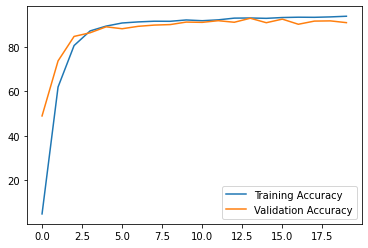

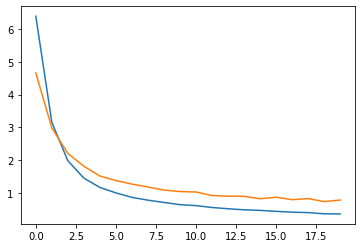

In [0]:
plt.plot(trainacc_resnet18_2, label = 'Training Accuracy')
plt.plot(validationacc_resnet18_2, label = 'Validation Accuracy')
plt.legend()
plt.show()
plt.plot(trainloss_resnet18_2, label = 'Training loss')
plt.plot(validationloss_resnet18_2, label = 'Validation loss')

In [0]:
trainacc_resnet18_2, validationacc_resnet18_2, trainloss_resnet18_2, validationloss_resnet18_2, resnet18_2 = train(resnet18_2, 0.0001 ,20, validationloader, testloader,trainacc_resnet18_2, validationacc_resnet18_2, trainloss_resnet18_2, validationloss_resnet18_2)

Epoch:  0  item:  644  total item:  1500


Epoch:  0  item:  644  total item:  1500
Epoch:  0 	Training accuracy:  92.22583328800992 	Validation accuracy:  98.22833853109742 	Training loss:  0.7601885884602865 	Validation loss:  0.3309295530319214


Epoch:  1  item:  644  total item:  1500


Epoch:  1  item:  644  total item:  1500
Epoch:  1 	Training accuracy:  90.71418351409986 	Validation accuracy:  97.40223407410056 	Training loss:  0.7302207895914714 	Validation loss:  0.3195448354085286


Epoch:  2  item:  644  total item:  1500


Epoch:  2  item:  644  total item:  1500
Epoch:  2 	Training accuracy:  89.50242769700449 	Validation accuracy:  96.3585438447719 	Training loss:  0.73942578125 	Validation loss:  0.3225026364326477


Epoch:  3  item:  644  total item:  1500


Epoch:  3  item:  644  total item:  1500
Epoch:  3 	Training accuracy:  92.39080138335314 	Validation accuracy:  96.8985218316116 	Training loss:  0.6537269420623779 	Validation loss:  0.3178633098602295


Epoch:  4  item:  644  total item:  1500


Epoch:  4  item:  644  total item:  1500
Epoch:  4 	Training accuracy:  91.9872228361454 	Validation accuracy:  98.23265490758872 	Training loss:  0.6413968938191732 	Validation loss:  0.3123804225921631


Epoch:  5  item:  644  total item:  1500


Epoch:  5  item:  644  total item:  1500
Epoch:  5 	Training accuracy:  92.51462087905765 	Validation accuracy:  97.41358939301028 	Training loss:  0.6150182139078776 	Validation loss:  0.363815237681071


Epoch:  6  item:  644  total item:  1500


Epoch:  6  item:  644  total item:  1500
Epoch:  6 	Training accuracy:  92.54513415914188 	Validation accuracy:  97.38213614242403 	Training loss:  0.5715833034515381 	Validation loss:  0.32495507144927976


Epoch:  7  item:  644  total item:  1500


Epoch:  7  item:  644  total item:  1500
Epoch:  7 	Training accuracy:  92.02188545334855 	Validation accuracy:  98.10295509405869 	Training loss:  0.5298000456492106 	Validation loss:  0.3302180229822795


Epoch:  8  item:  644  total item:  1500


Epoch:  8  item:  644  total item:  1500
Epoch:  8 	Training accuracy:  93.3388500907044 	Validation accuracy:  97.02351745811211 	Training loss:  0.5428690179189046 	Validation loss:  0.33092194016774495


Epoch:  9  item:  644  total item:  1500


Epoch:  9  item:  644  total item:  1500
Epoch:  9 	Training accuracy:  93.2093892794238 	Validation accuracy:  96.3804593666749 	Training loss:  0.5580514736175537 	Validation loss:  0.320579465230306


Epoch:  10  item:  644  total item:  1500


Epoch:  10  item:  644  total item:  1500
Epoch:  10 	Training accuracy:  93.48948692841884 	Validation accuracy:  96.30400080130356 	Training loss:  0.5229336496988932 	Validation loss:  0.3150996322631836


Epoch:  11  item:  644  total item:  1500


Epoch:  11  item:  644  total item:  1500
Epoch:  11 	Training accuracy:  94.27956856764779 	Validation accuracy:  97.00646021663434 	Training loss:  0.48135928726196286 	Validation loss:  0.3057340545654297


Epoch:  12  item:  644  total item:  1500


Epoch:  12  item:  644  total item:  1500
Epoch:  12 	Training accuracy:  93.9668923278872 	Validation accuracy:  98.27418710327278 	Training loss:  0.49195685068766276 	Validation loss:  0.34035323015848795


Epoch:  13  item:  644  total item:  1500


Epoch:  13  item:  644  total item:  1500
Epoch:  13 	Training accuracy:  94.47371658067182 	Validation accuracy:  97.08761349707014 	Training loss:  0.48040455945332844 	Validation loss:  0.3463410046895345


Epoch:  14  item:  644  total item:  1500


Epoch:  14  item:  644  total item:  1500
Epoch:  14 	Training accuracy:  93.86338033004822 	Validation accuracy:  96.95539626402571 	Training loss:  0.4707930253346761 	Validation loss:  0.31999109649658203


Epoch:  15  item:  644  total item:  1500


Epoch:  15  item:  644  total item:  1500
Epoch:  15 	Training accuracy:  95.27704557057088 	Validation accuracy:  97.60132688008609 	Training loss:  0.465582213083903 	Validation loss:  0.3721861349741618


Epoch:  16  item:  644  total item:  1500


Epoch:  16  item:  644  total item:  1500
Epoch:  16 	Training accuracy:  95.01413432231011 	Validation accuracy:  96.90036308780286 	Training loss:  0.4457129618326823 	Validation loss:  0.3153976043065389


Epoch:  17  item:  644  total item:  1500


Epoch:  17  item:  644  total item:  1500
Epoch:  17 	Training accuracy:  93.90976556219788 	Validation accuracy:  96.2526365400676 	Training loss:  0.4131606140136719 	Validation loss:  0.32663781611124676


Epoch:  18  item:  644  total item:  1500


Epoch:  18  item:  644  total item:  1500
Epoch:  18 	Training accuracy:  94.3437533382159 	Validation accuracy:  97.31332533640065 	Training loss:  0.42012661043802896 	Validation loss:  0.3206693115234375


Epoch:  19  item:  644  total item:  1500


Epoch:  19  item:  644  total item:  1500
Epoch:  19 	Training accuracy:  93.3851948445571 	Validation accuracy:  96.52554262110162 	Training loss:  0.36992629114786785 	Validation loss:  0.34229524103800457


In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18_2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 94 %


Task 2 Resnet18

In [0]:
# resnet18_entireLoss = []

In [0]:
resnet18_entire = models.resnet18(pretrained=True)

In [0]:
for parm in resnet18_entire.parameters():
  parm.requires_grad = True

In [0]:
resnet18_entire.fc = nn.Sequential(nn.Linear(in_features=512, out_features=210, bias=True),  nn.ReLU(inplace=True), nn.Dropout(p=0.5, inplace=False), nn.Linear(in_features=210, out_features=2, bias=True))

In [0]:
trainacc_resnet18_entire, validationacc_resnet18_entire, trainloss_resnet18_entire, validationloss_resnet18_entire = [], [], [], []

In [0]:
trainacc_resnet18_entire, validationacc_resnet18_entire, trainloss_resnet18_entire, validationloss_resnet18_entire, resnet18_entire = train(resnet18_entire, 0.0001 ,20, trainloader, validationloader, trainacc_resnet18_entire, validationacc_resnet18_entire, trainloss_resnet18_entire, validationloss_resnet18_entire)

Epoch:  0  item:  5984  total item:  12000


Epoch:  0  item:  644  total item:  1500
Epoch:  0 	Training accuracy:  82.69889817415442 	Validation accuracy:  84.6758581865839 	Training loss:  0.4290747202237447 	Validation loss:  0.43311148198445637


Epoch:  1  item:  5984  total item:  12000


Epoch:  1  item:  644  total item:  1500
Epoch:  1 	Training accuracy:  86.38155377786971 	Validation accuracy:  86.03341826832326 	Training loss:  0.3475978412628174 	Validation loss:  0.37373575592041014


Epoch:  2  item:  5984  total item:  12000


Epoch:  2  item:  644  total item:  1500
Epoch:  2 	Training accuracy:  88.42447987662351 	Validation accuracy:  88.08107130596079 	Training loss:  0.3010472575823466 	Validation loss:  0.3491009159088135


Epoch:  3  item:  5984  total item:  12000


Epoch:  3  item:  644  total item:  1500
Epoch:  3 	Training accuracy:  90.07043020819948 	Validation accuracy:  88.50327627258899 	Training loss:  0.2682976196606954 	Validation loss:  0.3254736334482829


Epoch:  4  item:  5984  total item:  12000


Epoch:  4  item:  644  total item:  1500
Epoch:  4 	Training accuracy:  90.41874987179662 	Validation accuracy:  90.12985782421018 	Training loss:  0.2517894406318665 	Validation loss:  0.3082965641021729


Epoch:  5  item:  5984  total item:  12000


Epoch:  5  item:  644  total item:  1500
Epoch:  5 	Training accuracy:  91.20554736239303 	Validation accuracy:  89.5084684848746 	Training loss:  0.23570337891578674 	Validation loss:  0.3170079886118571


Epoch:  6  item:  5984  total item:  12000


Epoch:  6  item:  644  total item:  1500
Epoch:  6 	Training accuracy:  91.57491692003934 	Validation accuracy:  91.57340138891983 	Training loss:  0.21984907722473143 	Validation loss:  0.31446954600016275


Epoch:  7  item:  5984  total item:  12000


Epoch:  7  item:  644  total item:  1500
Epoch:  7 	Training accuracy:  92.22878147530957 	Validation accuracy:  90.21216210059266 	Training loss:  0.20971521711349486 	Validation loss:  0.290133981068929


Epoch:  8  item:  5984  total item:  12000


Epoch:  8  item:  644  total item:  1500
Epoch:  8 	Training accuracy:  92.11285448340715 	Validation accuracy:  90.22367455163307 	Training loss:  0.20248187788327535 	Validation loss:  0.29690545876820884


Epoch:  9  item:  5984  total item:  12000


Epoch:  9  item:  644  total item:  1500
Epoch:  9 	Training accuracy:  92.77390675734084 	Validation accuracy:  90.0837553490571 	Training loss:  0.1933071162700653 	Validation loss:  0.2933236255645752


Epoch:  10  item:  5984  total item:  12000


Epoch:  10  item:  644  total item:  1500
Epoch:  10 	Training accuracy:  93.42187991765549 	Validation accuracy:  91.57379854334604 	Training loss:  0.18151523566246033 	Validation loss:  0.2909278144836426


Epoch:  11  item:  5984  total item:  12000


Epoch:  11  item:  644  total item:  1500
Epoch:  11 	Training accuracy:  93.09266666040739 	Validation accuracy:  93.4677746683926 	Training loss:  0.1809690549572309 	Validation loss:  0.2808936637242635


Epoch:  12  item:  5984  total item:  12000


Epoch:  12  item:  644  total item:  1500
Epoch:  12 	Training accuracy:  93.8811905724165 	Validation accuracy:  91.21892380282952 	Training loss:  0.17043957553307215 	Validation loss:  0.28106886609395343


Epoch:  13  item:  5984  total item:  12000


Epoch:  13  item:  644  total item:  1500
Epoch:  13 	Training accuracy:  94.19022813089751 	Validation accuracy:  91.39675430371167 	Training loss:  0.16843141088883082 	Validation loss:  0.29165946261088055


Epoch:  14  item:  5984  total item:  12000


Epoch:  14  item:  644  total item:  1500
Epoch:  14 	Training accuracy:  94.05907717016889 	Validation accuracy:  91.61735063858235 	Training loss:  0.16298426449298858 	Validation loss:  0.2975850467681885


Epoch:  15  item:  5984  total item:  12000


Epoch:  15  item:  644  total item:  1500
Epoch:  15 	Training accuracy:  94.42512028199492 	Validation accuracy:  91.66711230338987 	Training loss:  0.15586207946141561 	Validation loss:  0.2819742832183838


Epoch:  16  item:  5984  total item:  12000


Epoch:  16  item:  644  total item:  1500
Epoch:  16 	Training accuracy:  95.01734262759707 	Validation accuracy:  92.25101640805363 	Training loss:  0.15562201670805614 	Validation loss:  0.28355044428507487


Epoch:  17  item:  5984  total item:  12000


Epoch:  17  item:  644  total item:  1500
Epoch:  17 	Training accuracy:  94.7462351749253 	Validation accuracy:  91.32607559288302 	Training loss:  0.15061516561110813 	Validation loss:  0.2902264060974121


Epoch:  18  item:  5984  total item:  12000


Epoch:  18  item:  644  total item:  1500
Epoch:  18 	Training accuracy:  94.7117295029344 	Validation accuracy:  90.94035886094582 	Training loss:  0.1438410496711731 	Validation loss:  0.2904328708648682


Epoch:  19  item:  5984  total item:  12000


Epoch:  19  item:  644  total item:  1500
Epoch:  19 	Training accuracy:  95.17952066100216 	Validation accuracy:  91.55508873667974 	Training loss:  0.13969635453820228 	Validation loss:  0.2919157034556071


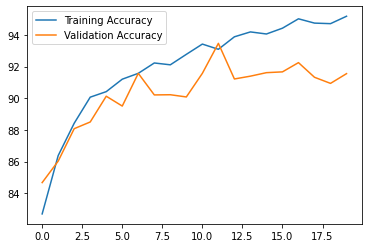

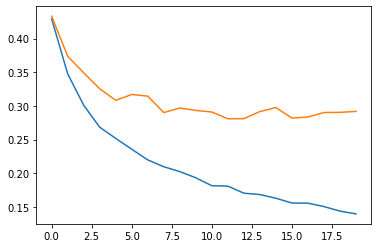

In [0]:
plt.plot(trainacc_resnet18_entire, label='Training Accuracy')
plt.plot(validationacc_resnet18_entire, label='Validation Accuracy')
plt.legend()
plt.show()

plt.plot(trainloss_resnet18_entire, label='Training loss')
plt.plot(validationloss_resnet18_entire, label='Validation loss')

In [0]:
trainacc_resnet18_entire, validationacc_resnet18_entire, trainloss_resnet18_entire, validationloss_resnet18_entire, resnet18_entire = train(resnet18_entire, 0.0001 ,20, validationloader, testloader, trainacc_resnet18_entire, validationacc_resnet18_entire, trainloss_resnet18_entire, validationloss_resnet18_entire)

Epoch:  0  item:  644  total item:  1500


Epoch:  0  item:  644  total item:  1500
Epoch:  0 	Training accuracy:  91.19146102165931 	Validation accuracy:  98.55770089612406 	Training loss:  0.28191618156433107 	Validation loss:  0.1290700585047404


Epoch:  1  item:  644  total item:  1500


Epoch:  1  item:  644  total item:  1500
Epoch:  1 	Training accuracy:  90.87311115799392 	Validation accuracy:  98.35026003085471 	Training loss:  0.26890622774759926 	Validation loss:  0.1311420839627584


Epoch:  2  item:  644  total item:  1500


Epoch:  2  item:  644  total item:  1500
Epoch:  2 	Training accuracy:  92.725466714691 	Validation accuracy:  98.08884813114675 	Training loss:  0.250560365041097 	Validation loss:  0.14035927931467693


Epoch:  3  item:  644  total item:  1500


Epoch:  3  item:  644  total item:  1500
Epoch:  3 	Training accuracy:  92.4536469764428 	Validation accuracy:  97.9194534387824 	Training loss:  0.2311604846318563 	Validation loss:  0.13182367436091105


Epoch:  4  item:  448  total item:  1500

In [0]:
torch.save(resnet18_entire.state_dict() ,'/content/drive/My Drive/Data/MSDS/Semester2/Deeplearning/assignment5_2/resnet18_entire.pth')

In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18_entire(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 95 %


In [0]:
nb_classes = 2

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(testloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = resnet18_entire(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[569.,  46.],
        [ 17., 868.]])


In [0]:
nb_classes = 2
confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(validationloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = resnet18_entire(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[542.,  73.],
        [ 58., 827.]])
